In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [11]:
# Connexion
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='8GB';")

print("DuckDB ready")

DuckDB ready


In [4]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v1 AS
SELECT
    session_type,
    session_date,
    player_id AS sensor_id,
    time_utc,
    x_pos,
    y_pos,
    latitude,
    longitude,
    speed_kmh
FROM tracking
""")

In [29]:
df_map = (
    pd.read_csv("data/summary.csv", sep=",")
    .assign(
        session_date=lambda x: pd.to_datetime(
            x["date"],
            format="%Y-%m-%d %H:%M:%S",
            errors="raise"   
        ).dt.date
    )
    .rename(columns={
        "Sensor": "sensor_id",
        "last_name": "player_id"
    })
    [["session_date", "sensor_id", "player_id"]]
    .drop_duplicates()
)

print(df_map.head())

con.register("sensor_player_map", df_map)

con.execute("""
CREATE OR REPLACE VIEW mapping_v AS
SELECT * FROM sensor_player_map
""")

  session_date  sensor_id  player_id
0   2020-02-01          4   KNEZEVIC
1   2020-02-01          5      ALVES
2   2020-02-01          9  MARGIOTTA
3   2020-02-01         10      ELEKE
4   2020-02-01         11    SCHURPF


In [23]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v2 AS
SELECT
    t.*,
    m.player_id
FROM tracking_v1 t
LEFT JOIN mapping_v m
ON t.sensor_id = m.sensor_id
AND t.session_date = m.session_date
""")

In [24]:
unmapped = con.execute("""
SELECT
    session_date,
    sensor_id,
    COUNT(*) AS n_rows
FROM tracking_v2
WHERE player_id IS NULL
GROUP BY session_date, sensor_id
ORDER BY n_rows DESC
""").df()

print(unmapped.head())

  session_date  sensor_id  n_rows
0   2019-10-10          7   36851


Étant donné que sur le capteur 7 plusieurs personnes ont été attribuées, je ne peux pas définir cette session à quelqu'un.

In [25]:
con.execute("""
CREATE OR REPLACE TABLE tracking_player AS
SELECT *
FROM tracking_v2
WHERE player_id IS NOT NULL;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [26]:
summary = con.execute("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT player_id) AS n_players,
    COUNT(DISTINCT session_date) AS n_sessions,
    COUNT(DISTINCT sensor_id) AS n_sensors
FROM tracking_player
""").df()
summary2 = con.execute("""
SELECT
    session_type,
    COUNT(DISTINCT session_date) AS n_sessions
FROM tracking_player
GROUP BY session_type;
""").df()

print(summary)
print(summary2)

      n_rows  n_players  n_sessions  n_sensors
0  166541023         42         258         29
  session_type  n_sessions
0         game          74
1     practice         187


Pseudonomisation

In [27]:
# Extraire les joueurs
player = con.execute("""
SELECT DISTINCT player_id
FROM tracking_player
""").df()

# Attribuer un numéro à chaque joueur
player['player_number'] = np.arange(1, len(player) + 1)

# Sauvegarder le mapping
player.to_csv("data/player_numbering.txt", index=False, header=True)

# Créer une table temporaire dans DuckDB
con.register("player_numbered", player)

# Récupérer tous les noms de colonnes sauf player_id
cols = con.execute("PRAGMA table_info(tracking_player)").df()
cols = [c for c in cols['name'] if c != 'player_id']
cols_sql = ", ".join([f"tp.{c}" for c in cols])

# Créer la vue avec le pseudo
con.execute(f"""
CREATE OR REPLACE TABLE tracking_pseudo AS
SELECT
    {cols_sql},
    pn.player_number AS player_pseudo
FROM tracking_player tp
JOIN player_numbered pn ON tp.player_id = pn.player_id
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [33]:
#Afficher view tracking_pseudo
df_pseudo = con.execute("""
SELECT * FROM tracking_pseudo LIMIT 50
""").df()
print(df_pseudo)

   session_type session_date  sensor_id                time_utc      x_pos  \
0          game   2020-07-12          5 2020-07-12 14:46:53.700  40.358087   
1          game   2020-07-12          5 2020-07-12 14:46:53.800  39.935954   
2          game   2020-07-12          5 2020-07-12 14:46:53.900  39.538048   
3          game   2020-07-12          5 2020-07-12 14:46:54.000  39.141564   
4          game   2020-07-12          5 2020-07-12 14:46:54.100  38.749350   
5          game   2020-07-12          5 2020-07-12 14:46:54.200  38.378979   
6          game   2020-07-12          5 2020-07-12 14:46:54.300  37.996725   
7          game   2020-07-12          5 2020-07-12 14:46:54.400  37.677155   
8          game   2020-07-12          5 2020-07-12 14:46:54.500  37.335279   
9          game   2020-07-12          5 2020-07-12 14:46:54.600  36.953986   
10         game   2020-07-12          5 2020-07-12 14:46:54.700  36.728441   
11         game   2020-07-12          5 2020-07-12 14:46:54.800 

In [36]:
df_sessions = con.execute("""
SELECT DISTINCT session_date
FROM tracking_pseudo
WHERE player_pseudo = 20
  AND YEAR(session_date) = 2020
ORDER BY session_date
""").df()

print(df_sessions)

   session_date
0    2020-01-06
1    2020-01-08
2    2020-01-09
3    2020-01-10
4    2020-01-11
5    2020-01-16
6    2020-01-20
7    2020-01-29
8    2020-01-31
9    2020-02-03
10   2020-02-04
11   2020-02-05
12   2020-02-06
13   2020-02-08
14   2020-02-09
15   2020-02-11
16   2020-02-16
17   2020-02-18
18   2020-02-19
19   2020-02-21
20   2020-02-22
21   2020-06-02
22   2020-06-03
23   2020-06-06
24   2020-11-11
25   2020-11-12
26   2020-11-16
27   2020-11-18
28   2020-11-20
29   2020-11-24
30   2020-11-25
31   2020-11-27
32   2020-11-28
33   2020-11-30
34   2020-12-02
35   2020-12-05
36   2020-12-06
37   2020-12-10
38   2020-12-11
39   2020-12-12
40   2020-12-15
41   2020-12-16
42   2020-12-20
43   2020-12-23


## Clean vitesse abérante

In [218]:
# ============================================================================
# ÉTAPE 1 : DÉTECTION DES OUTLIERS PAR VITESSE EXCESSIVE
# ============================================================================

# Votre détection actuelle (identifie les sessions problématiques)
con.execute(f"""
CREATE OR REPLACE VIEW extreme_vitesse AS
SELECT
    player_pseudo,
    session_date,
    sensor_id,
    MAX(speed_kmh) AS max_speed
FROM tracking_pseudo
GROUP BY player_pseudo, session_date, sensor_id
HAVING MAX(speed_kmh) > 35;
""").df()

# ============================================================================
# ÉTAPE 2 : IDENTIFIER LES POINTS EXACTS AVEC OUTLIERS (VERSION AMÉLIORÉE)
# ============================================================================


def detect_outlier_sequences_position_z(df, z_threshold=3):
    """
    Détecte les outliers par position en utilisant la cote Z (écart-type à partir de la moyenne).
    z_threshold : nombre d'écarts-types pour considérer un point comme outlier.
    """
    df = df.sort_values('time_utc').reset_index(drop=True)
    
    mean_x = df['x_pos'].mean()
    std_x = df['x_pos'].std()
    mean_y = df['y_pos'].mean()
    std_y = df['y_pos'].std()
    
    # Calculer la cote Z pour x et y
    df['z_x'] = (df['x_pos'] - mean_x) / std_x
    df['z_y'] = (df['y_pos'] - mean_y) / std_y
    
    # Distance combinée en termes de cote Z
    df['z_dist'] = np.sqrt(df['z_x']**2 + df['z_y']**2)
    
    # Détection des outliers
    df['is_outlier_position'] = df['z_dist'] > z_threshold
    
    # Détecter START et END
    df['outlier_start_position'] = False
    df['outlier_end_position'] = False
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_position'] and not in_sequence:
            df.loc[i, 'outlier_start_position'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_position'] and in_sequence:
            df.loc[i-1, 'outlier_end_position'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_position'] = True

    nb_outliers = df['is_outlier_position'].sum()
    nb_sequences = df['outlier_start_position'].sum()
    print(f"  Points outliers position : {nb_outliers} ({nb_outliers/len(df)*100:.1f}%)")
    print(f"  Séquences position       : {nb_sequences}")
    
    return df

def detect_local_outliers_speed_iqr_global_iqr(df, speed_trigger=35, window_sec=5, multiplier=1.5):
    """
    Détecte les outliers de vitesse localement autour des pics, 
    mais en utilisant l'IQR calculé sur l'ensemble de la session.
    
    df : DataFrame avec colonnes 'time_utc' et 'speed_kmh'
    speed_trigger : seuil pour considérer un point comme pic
    window_sec : fenêtre temporelle autour du pic (en secondes)
    multiplier : multiplicateur de l'IQR pour définir les bornes
    """
    df = df.sort_values('time_utc').reset_index(drop=True)
    df['is_outlier_speed'] = False

    # --- Calcul IQR global sur toute la session ---
    Q1_global = df['speed_kmh'].quantile(0.25)
    Q3_global = df['speed_kmh'].quantile(0.75)
    IQR_global = Q3_global - Q1_global
    lower_global = Q1_global - multiplier * IQR_global
    upper_global = Q3_global + multiplier * IQR_global

    # --- Trouver les pics ---
    peaks = df[df['speed_kmh'] > speed_trigger]['time_utc']

    for peak_time in peaks:
        # Définir la fenêtre locale autour du pic
        start_time = peak_time - pd.Timedelta(seconds=window_sec)
        end_time = peak_time + pd.Timedelta(seconds=window_sec)

        # Marquer comme outlier uniquement les points dans cette fenêtre
        mask = (
            (df['time_utc'] >= start_time) & 
            (df['time_utc'] <= end_time) &
            ((df['speed_kmh'] < lower_global) | (df['speed_kmh'] > upper_global))
        )

        df.loc[mask, 'is_outlier_speed'] = True

    # --- Détection des séquences continues ---
    df['outlier_start_speed'] = False
    df['outlier_end_speed'] = False
    in_sequence = False
    for i in range(len(df)):
        if df.loc[i, 'is_outlier_speed'] and not in_sequence:
            df.loc[i, 'outlier_start_speed'] = True
            in_sequence = True
        elif not df.loc[i, 'is_outlier_speed'] and in_sequence:
            df.loc[i-1, 'outlier_end_speed'] = True
            in_sequence = False
    if in_sequence:
        df.loc[len(df)-1, 'outlier_end_speed'] = True

    return df




# Récupérer toutes les sessions avec vitesse excessive
sessions_to_analyze = con.execute("""
SELECT DISTINCT 
    player_pseudo,
    session_date,
    sensor_id
FROM extreme_vitesse
ORDER BY player_pseudo, session_date, sensor_id
""").df()

print(f"\n{'='*70}")
print(f"ÉTAPE 2 : DÉTECTION PRÉCISE DES OUTLIERS")
print(f"{'='*70}")
print(f"Sessions à analyser : {len(sessions_to_analyze)}\n")

# Créer une table temporaire pour stocker tous les outliers
con.execute("""
CREATE OR REPLACE TABLE outliers_points (
    player_pseudo VARCHAR,
    session_date DATE,
    sensor_id VARCHAR,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE,
    is_outlier_combined BOOLEAN,
    outlier_start_combined BOOLEAN,
    outlier_end_combined BOOLEAN
)
""")

# Analyser chaque session
for idx, session in sessions_to_analyze.iterrows():
    player = session['player_pseudo']
    date = session['session_date']
    sensor = session['sensor_id']
    
    print(f"[{idx+1}/{len(sessions_to_analyze)}] Joueur {player} - {date} - Sensor {sensor}")
    
    # Récupérer les données de cette session
    df_session = con.execute(f"""
    SELECT 
        player_pseudo,
        session_date,
        sensor_id,
        time_utc,
        x_pos,
        y_pos,
        speed_kmh
    FROM tracking_pseudo
    WHERE player_pseudo = '{player}'
    AND session_date = '{date}'
    AND sensor_id = '{sensor}'
    ORDER BY time_utc
    """).df()
    
        # Détecter les outliers par position et vitesse
    df_with_outliers = detect_outlier_sequences_position_z(df_session, z_threshold=3)
    df_with_outliers = detect_local_outliers_speed_iqr_global_iqr(df_with_outliers, multiplier=1.5)

    # Fusionner position + vitesse
    df_with_outliers['is_outlier_combined'] = df_with_outliers['is_outlier_position'] | df_with_outliers['is_outlier_speed']
    df_with_outliers['outlier_start_combined'] = df_with_outliers['outlier_start_position'] | df_with_outliers['outlier_start_speed']
    df_with_outliers['outlier_end_combined'] = df_with_outliers['outlier_end_position'] | df_with_outliers['outlier_end_speed']

    # Colonnes à sauvegarder
    df_to_save = df_with_outliers[[
        'player_pseudo', 'session_date', 'sensor_id', 'time_utc',
        'x_pos', 'y_pos', 'speed_kmh', 
        'is_outlier_combined', 'outlier_start_combined', 'outlier_end_combined'
    ]]
    
    # Insérer dans DuckDB
    con.register('temp_outliers', df_to_save)
    con.execute("""
    INSERT INTO outliers_points 
    SELECT * FROM temp_outliers
    """)
    con.unregister('temp_outliers')

print(f"\n✅ Détection terminée - Résultats dans 'outliers_points'")

# Vérification
verification = con.execute("""
SELECT 
    COUNT(*) as total_points,
    SUM(CASE WHEN is_outlier_combined THEN 1 ELSE 0 END) as nb_outliers,
    SUM(CASE WHEN outlier_start_combined THEN 1 ELSE 0 END) as nb_sequences
FROM outliers_points
""").df()

print("\n" + "="*70)
print("RÉSUMÉ DE LA DÉTECTION")
print("="*70)
print(verification)

# ============================================================================
# ÉTAPE 3 : IDENTIFIER LES SÉQUENCES CONTINUES D'OUTLIERS
# ============================================================================

con.execute("""
CREATE OR REPLACE TABLE outlier_sequences AS
WITH numbered_outliers AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_date, sensor_id 
            ORDER BY time_utc
        ) as row_num,
        -- Créer un groupe pour chaque séquence continue
        -- Si is_outlier change, le groupe change
        ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_date, sensor_id 
            ORDER BY time_utc
        ) - ROW_NUMBER() OVER (
            PARTITION BY player_pseudo, session_date, sensor_id, is_outlier_combined
            ORDER BY time_utc
        ) as sequence_group
    FROM outliers_points
),
sequences AS (
    SELECT 
        player_pseudo,
        session_date,
        sensor_id,
        is_outlier_combined,
        sequence_group,
        MIN(time_utc) as seq_start_time,
        MAX(time_utc) as seq_end_time,
        COUNT(*) as seq_length,
        MIN(row_num) as start_row,
        MAX(row_num) as end_row
    FROM numbered_outliers
    GROUP BY player_pseudo, session_date, sensor_id, is_outlier_combined, sequence_group
)
SELECT 
    player_pseudo,
    session_date,
    sensor_id,
    is_outlier_combined,
    sequence_group,
    seq_start_time,
    seq_end_time,
    seq_length,
    EXTRACT(EPOCH FROM (seq_end_time - seq_start_time)) as duration_seconds,
    start_row,
    end_row
FROM sequences
WHERE is_outlier_combined = TRUE  -- Garder seulement les séquences d'outliers
ORDER BY player_pseudo, session_date, sensor_id, seq_start_time
""")

print("✅ Table outlier_sequences créée")

# Afficher les séquences détectées
sequences_summary = con.execute("""
SELECT 
    player_pseudo,
    session_date,
    sensor_id,
    COUNT(*) as nb_sequences,
    SUM(seq_length) as total_outlier_points
FROM outlier_sequences
GROUP BY player_pseudo, session_date, sensor_id
ORDER BY nb_sequences DESC
""").df()

print("\n=== RÉSUMÉ DES SÉQUENCES D'OUTLIERS PAR SESSION ===")
print(sequences_summary)


ÉTAPE 2 : DÉTECTION PRÉCISE DES OUTLIERS
Sessions à analyser : 46

[1/46] Joueur 1 - 2019-09-14 00:00:00 - Sensor 14
  Points outliers position : 1105 (2.6%)
  Séquences position       : 1
[2/46] Joueur 1 - 2020-03-13 00:00:00 - Sensor 14
  Points outliers position : 785 (1.8%)
  Séquences position       : 5
[3/46] Joueur 2 - 2021-01-08 00:00:00 - Sensor 10
  Points outliers position : 1361 (3.1%)
  Séquences position       : 1
[4/46] Joueur 4 - 2019-07-08 00:00:00 - Sensor 7
  Points outliers position : 127 (0.3%)
  Séquences position       : 2
[5/46] Joueur 6 - 2019-09-18 00:00:00 - Sensor 10
  Points outliers position : 1788 (3.4%)
  Séquences position       : 2
[6/46] Joueur 6 - 2020-03-04 00:00:00 - Sensor 10
  Points outliers position : 2891 (8.0%)
  Séquences position       : 1
[7/46] Joueur 10 - 2020-03-13 00:00:00 - Sensor 4
  Points outliers position : 391 (0.9%)
  Séquences position       : 2
[8/46] Joueur 10 - 2020-11-04 00:00:00 - Sensor 4
  Points outliers position : 834

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Table outlier_sequences créée

=== RÉSUMÉ DES SÉQUENCES D'OUTLIERS PAR SESSION ===
   player_pseudo session_date sensor_id  nb_sequences  total_outlier_points
0             36   2020-07-05         9            19                1711.0
1             24   2020-02-06        11             5                1308.0
2              1   2020-03-13        14             5                 785.0
3             15   2020-10-03         7             4                 231.0
4             36   2020-03-13         9             4                 831.0
5             12   2020-03-13        15             4                 443.0
6             25   2019-07-08         1             4                 588.0
7              4   2019-07-08         7             3                 212.0
8             39   2019-09-18        21             3                1936.0
9             14   2020-03-13        13             3                 508.0
10            40   2020-03-13         2             2                1570.0
11 

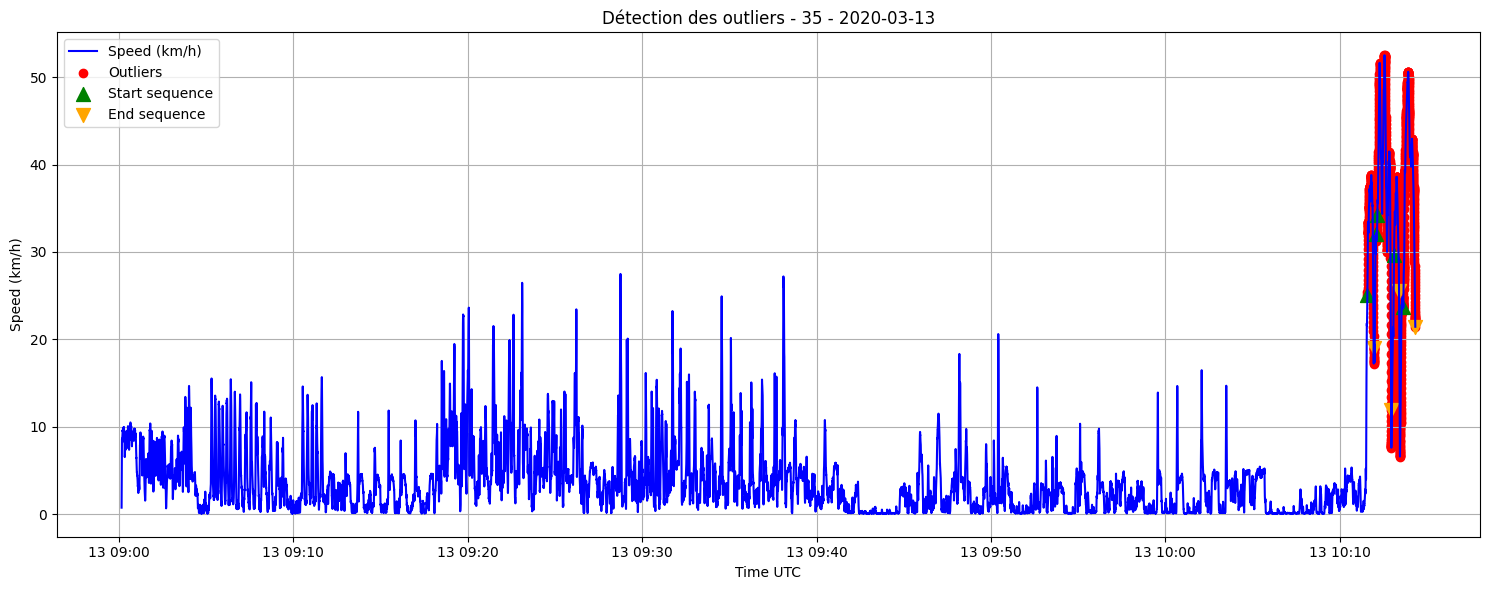

In [219]:

# === PARAMÈTRES DE FILTRAGE ===
player_to_plot = '35'       # Remplacer par le pseudo à visualiser
date_to_plot = '2020-03-13'      # Remplacer par la date à visualiser

# === RÉCUPÉRER LES DONNÉES DE LA SESSION ===
df_session = con.execute(f"""
SELECT t.player_pseudo, t.session_date, t.time_utc,
       t.x_pos, t.y_pos, t.speed_kmh,
       o.is_outlier_combined,
       o.outlier_start_combined,
       o.outlier_end_combined
FROM tracking_pseudo t
LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
  AND t.session_date = o.session_date
  AND t.sensor_id = o.sensor_id
  AND t.time_utc = o.time_utc
WHERE t.player_pseudo = '{player_to_plot}'
  AND t.session_date = '{date_to_plot}'
ORDER BY t.time_utc
""").df()

# === PLOT POSITIONS ET OUTLIERS ===
plt.figure(figsize=(15,6))

# Courbe principale (position ou vitesse)
plt.plot(df_session['time_utc'], df_session['speed_kmh'], label='Speed (km/h)', color='blue')

# Points outliers
outliers = df_session[df_session['is_outlier_combined']]
plt.scatter(outliers['time_utc'], outliers['speed_kmh'], color='red', label='Outliers')

# Start / End des séquences
start_points = df_session[df_session['outlier_start_combined']]
end_points = df_session[df_session['outlier_end_combined']]

plt.scatter(start_points['time_utc'], start_points['speed_kmh'], 
            color='green', marker='^', s=100, label='Start sequence')
plt.scatter(end_points['time_utc'], end_points['speed_kmh'], 
            color='orange', marker='v', s=100, label='End sequence')

plt.title(f"Détection des outliers - {player_to_plot} - {date_to_plot}")
plt.xlabel("Time UTC")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [220]:
# ============================================================================ 
# ÉTAPE 4 : CORRECTION PAR IMPUTATION PAR LA MOYENNE (TOUS LES JOUEURS)
# ============================================================================

# Récupérer toutes les sessions avec outliers détectés
sessions_to_correct = con.execute("""
SELECT DISTINCT player_pseudo, session_date, sensor_id
FROM outliers_points
ORDER BY player_pseudo, session_date, sensor_id
""").df()

print(f"Nombre de sessions à corriger : {len(sessions_to_correct)}")

# Créer une table corrigée avec uniquement les colonnes utiles
con.execute("""
CREATE OR REPLACE TABLE tracking_corrected (
    player_pseudo VARCHAR,
    session_date DATE,
    sensor_id VARCHAR,
    time_utc TIMESTAMP,
    x_pos DOUBLE,
    y_pos DOUBLE,
    speed_kmh DOUBLE
)
""")

# Boucle sur chaque session
for idx, session in sessions_to_correct.iterrows():
    player = session['player_pseudo']
    date = session['session_date']
    sensor = session['sensor_id']
    
    # Récupérer les données de la session avec le marquage des outliers
    df_session = con.execute(f"""
    SELECT t.player_pseudo, t.session_date, t.sensor_id, t.time_utc,
           t.x_pos, t.y_pos, t.speed_kmh,
           o.is_outlier_combined
    FROM tracking_pseudo t
    LEFT JOIN outliers_points o
      ON t.player_pseudo = o.player_pseudo
      AND t.session_date = o.session_date
      AND t.sensor_id = o.sensor_id
      AND t.time_utc = o.time_utc
    WHERE t.player_pseudo = '{player}'
      AND t.session_date = '{date}'
      AND t.sensor_id = '{sensor}'
    ORDER BY t.time_utc
    """).df()
    
    # Calculer les moyennes sur les points valides (hors outliers)
    valid_points = df_session[~df_session['is_outlier_combined']]
    mean_speed = valid_points['speed_kmh'].mean()
    mean_x = valid_points['x_pos'].mean()
    mean_y = valid_points['y_pos'].mean()
    
    # Imputer les outliers par la moyenne
    df_session.loc[df_session['is_outlier_combined'], 'speed_kmh'] = mean_speed
    df_session.loc[df_session['is_outlier_combined'], 'x_pos'] = mean_x
    df_session.loc[df_session['is_outlier_combined'], 'y_pos'] = mean_y
    
    # Supprimer la colonne is_outlier_combined avant insertion
    df_to_save = df_session.drop(columns=['is_outlier_combined'])
    
    # Insérer dans la table corrigée
    con.register('temp_corrected', df_to_save)
    con.execute("""
    INSERT INTO tracking_corrected 
    SELECT * FROM temp_corrected
    """)
    con.unregister('temp_corrected')
    
    print(f"[{idx+1}/{len(sessions_to_correct)}] Session {player} - {date} corrigée")

print("\n✅ Toutes les sessions ont été corrigées et stockées dans 'tracking_corrected'")

Nombre de sessions à corriger : 46
[1/46] Session 1 - 2019-09-14 00:00:00 corrigée
[2/46] Session 1 - 2020-03-13 00:00:00 corrigée
[3/46] Session 10 - 2020-03-13 00:00:00 corrigée
[4/46] Session 10 - 2020-11-04 00:00:00 corrigée
[5/46] Session 10 - 2020-11-11 00:00:00 corrigée
[6/46] Session 10 - 2021-01-08 00:00:00 corrigée
[7/46] Session 11 - 2020-03-13 00:00:00 corrigée
[8/46] Session 11 - 2021-01-08 00:00:00 corrigée
[9/46] Session 12 - 2020-03-13 00:00:00 corrigée
[10/46] Session 13 - 2021-01-11 00:00:00 corrigée
[11/46] Session 14 - 2020-03-13 00:00:00 corrigée
[12/46] Session 15 - 2020-01-20 00:00:00 corrigée
[13/46] Session 15 - 2020-09-16 00:00:00 corrigée
[14/46] Session 15 - 2020-10-03 00:00:00 corrigée
[15/46] Session 16 - 2020-03-13 00:00:00 corrigée
[16/46] Session 19 - 2020-01-24 00:00:00 corrigée
[17/46] Session 2 - 2021-01-08 00:00:00 corrigée
[18/46] Session 20 - 2021-01-08 00:00:00 corrigée
[19/46] Session 24 - 2020-02-06 00:00:00 corrigée
[20/46] Session 24 - 2020-0

In [221]:
#afficher session vitesse superieur a 45 km/h 
con.execute("""SELECT
    player_pseudo,
    session_date,
    sensor_id,
    time_utc,
    speed_kmh
FROM tracking_corrected
WHERE speed_kmh > 35
--- IGNORE ---
""").df()

,player_pseudo,session_date,sensor_id,time_utc,speed_kmh


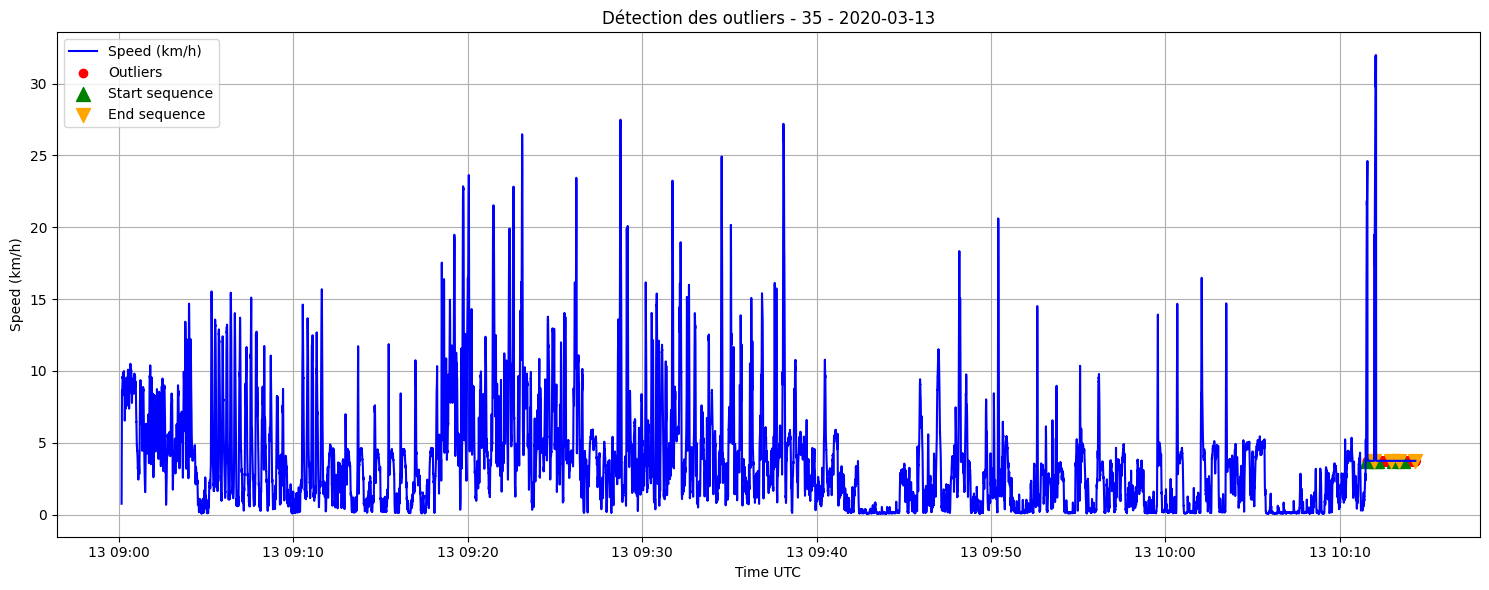

In [222]:

# === PARAMÈTRES DE FILTRAGE ===
player_to_plot = '35'       # Remplacer par le pseudo à visualiser
date_to_plot = '2020-03-13'      # Remplacer par la date à visualiser

# === RÉCUPÉRER LES DONNÉES DE LA SESSION ===
df_session = con.execute(f"""
SELECT t.player_pseudo, t.session_date, t.time_utc,
       t.x_pos, t.y_pos, t.speed_kmh,
       o.is_outlier_combined,
       o.outlier_start_combined,
       o.outlier_end_combined
FROM tracking_corrected t
LEFT JOIN outliers_points o
  ON t.player_pseudo = o.player_pseudo
  AND t.session_date = o.session_date
  AND t.sensor_id = o.sensor_id
  AND t.time_utc = o.time_utc
WHERE t.player_pseudo = '{player_to_plot}'
  AND t.session_date = '{date_to_plot}'
ORDER BY t.time_utc
""").df()

# === PLOT POSITIONS ET OUTLIERS ===
plt.figure(figsize=(15,6))

# Courbe principale (position ou vitesse)
plt.plot(df_session['time_utc'], df_session['speed_kmh'], label='Speed (km/h)', color='blue')

# Points outliers
outliers = df_session[df_session['is_outlier_combined']]
plt.scatter(outliers['time_utc'], outliers['speed_kmh'], color='red', label='Outliers')

# Start / End des séquences
start_points = df_session[df_session['outlier_start_combined']]
end_points = df_session[df_session['outlier_end_combined']]

plt.scatter(start_points['time_utc'], start_points['speed_kmh'], 
            color='green', marker='^', s=100, label='Start sequence')
plt.scatter(end_points['time_utc'], end_points['speed_kmh'], 
            color='orange', marker='v', s=100, label='End sequence')

plt.title(f"Détection des outliers - {player_to_plot} - {date_to_plot}")
plt.xlabel("Time UTC")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()